## Estimating RSSNR from existing CReSIS MCoRDS data

The purpose of this notebook is to explain how required surface SNR is derived from data collected by CReSIS's MCoRDS system.

This notebook uses data from the CReSIS data portal: https://data.cresis.ku.edu/

> We acknowledge the use of data and/or data products from CReSIS generated with support from the University of Kansas, NASA Operation IceBridge grant NNX16AH54G, NSF grants ACI-1443054, OPP-1739003, and IIS-1838230, Lilly Endowment Incorporated, and Indiana METACyt Initiative.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import cartopy.crs as ccrs
import pathlib
import re

In [2]:
e_ice = 3.17 # dielectric permittivity of ice
sig_speed_ice = scipy.constants.speed_of_light / np.sqrt(e_ice)

### Getting data

If you just want to test-run this notebook, you can run `download_example_data_summit.sh` in the `example_data_summit/` directory. That will download five segments of MCoRDS data in the vicinity of Summit Station in Greenland. The total size of the data is about 84 MB.

To apply this in another location, you should use the Open Polar Server tools to find MCoRDS data segments in the vicinty of your field site: https://ops.cresis.ku.edu/

We recommend that you follow the Summit example and create a bash script to automatically download the relevant data files. For each segment, you will need to the radar data file (see notes below) and the surface and bed picks out of the `CSV_good` directory. Take a look at `download_example_data_summit.sh` for examples.

Notes on the radar data files:

1. You can use either the `CSARP_qlook` (unfocused) or `CSARP_standard` (SAR focused) data products. We generally use qlook, but it generally shouldn't make a big difference. On the summit example, it change the 10th and 90th percentiles of RSSNR by less than 2 dB.
2. It is very important to use the combined data and not the indidivudal outputs of each waveform in the "waveform playlist." In short, **do not use any data file containing `img` in the filename.** Most MCoRDS data is collected from 3 waveforms at different lengths and powers, optimized for shallow, medium, and deep sounding. The merged data files should generally be radiometrically accurate from surface to bed, however the individual files (the ones with `img` in the filename) often have saturation effects on the surface, which would artificially deflate the RSSNR.

In [3]:
def load_cresis_data(l1_hdf5_path, l2_csv_path):
    f = h5py.File(l1_hdf5_path, 'r')
    l2 = pd.read_csv(l2_csv_path)

    # Match (nearest neighbors interpolate) the L2 data to the L1 data
    l2_interp_idx = scipy.interpolate.NearestNDInterpolator(l2[['LAT', 'LON']], l2.index)
    l2_idxs = l2_interp_idx(np.squeeze(np.array([f['Latitude'], f['Longitude']])).T) # Indices in the L2 CSV file to match the L1 data

    # Extract the surface and bed picks from the L2 data
    surface_m = l2['SURFACE'].iloc[l2_idxs]
    bed_m = l2['BOTTOM'].iloc[l2_idxs]
    ice_thickness_m = bed_m - surface_m

    # Convert surface and bed back to two-way travel time in seconds
    surface_s = 2*surface_m / scipy.constants.c
    bed_s = surface_s + (2*ice_thickness_m / sig_speed_ice)

    fast_time = np.squeeze(np.array(f['Time']))
    slow_time = np.squeeze(np.array(f['GPS_time']))
    slow_time_rel = slow_time - slow_time[0]
    pwr_db = 10*np.log10(np.array(f['Data'])).T

    return {
        'l1_data': f,
        'fast_time': fast_time,
        'slow_time': slow_time,
        'slow_time_rel': slow_time_rel,
        'pwr_db': pwr_db,
        'surface_s': surface_s,
        'bed_s': bed_s,
        'surface_m': surface_m,
        'ice_thickness_m': ice_thickness_m,
        'latitude': np.squeeze(np.array(f['Latitude'])),
        'longitude': np.squeeze(np.array(f['Longitude']))
    }

Change the `data_path` here to point to your directory of data files. Check the output for any errors in matching between CSV and MAT files.

In [4]:
data_path = "example_data_summit/"

lines = {}
data_root = pathlib.Path(data_path)

key_re = re.compile(r"(\d{8}_\d{2}_\d{3})")

# Make a dictionary of CSV files by key
csv_file_paths = {}
for csv_file in data_root.rglob("*.csv"):
    key_match = key_re.search(csv_file.name)
    if not key_match:
        print(f"Warning: File {csv_file.name} does not match expected pattern.")
        continue
    key = key_match.group(1)
    csv_file_paths[key] = csv_file

# find every .mat under the CSARP qlook directory
for mat_file in data_root.rglob("*.mat"):

    # Skip any files containing "img" in the filename -- these are uncombined files and may have saturation
    if "img" in mat_file.name:
        print(f"Skipping {mat_file.name} due to 'img' in filename indiciating uncombined data.")
        print("See note at the top of the notebook about why these files should not be used.")
        continue
    
    # extract the key from the filename, e.g., "20200101_01_001.mat" -> "20200101_01_001"
    key_match = key_re.search(mat_file.name)
    if not key_match:
        print(f"Warning: File {mat_file.name} does not match expected pattern.")
        continue
    
    # look for the matching .csv
    key = key_match.group(1)
    if key not in csv_file_paths:
        print(f"Warning: No matching CSV file for {key}.")
        continue
    
    csv_file = csv_file_paths[key]
    
    print(f"Loading {mat_file} and {csv_file}...")
    # load the data
    if key in lines:
        print(f"Warning: Duplicate key {key} found. Overwriting previous data.")
    else:
        lines[key] = load_cresis_data(mat_file, csv_file)
    

Loading example_data_summit/Data_20190512_01_057.mat and example_data_summit/Data_20190512_01_057.csv...
Loading example_data_summit/Data_20180501_01_038.mat and example_data_summit/Data_20180501_01_038.csv...
Loading example_data_summit/Data_20180423_01_052.mat and example_data_summit/Data_20180423_01_052.csv...
Loading example_data_summit/Data_20190512_01_047.mat and example_data_summit/Data_20190512_01_047.csv...
Loading example_data_summit/Data_20180423_01_053.mat and example_data_summit/Data_20180423_01_053.csv...


### Check radargrams and picking

This is mostly a sanity check. You should take a look through the rendered radargrams, paying particular attention to:

1. Does the data look acceptably good? If you have junk data, skip it.
2. Are the surface and bed picks correct? Incorrect picks will break this process.
3. Does it look like the combining process correctly merged the different waveforms? You should not see any abrupt jumps in power at the same delay time.

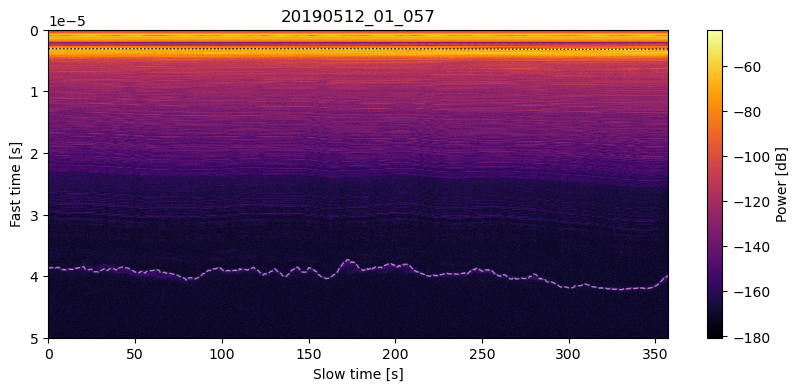

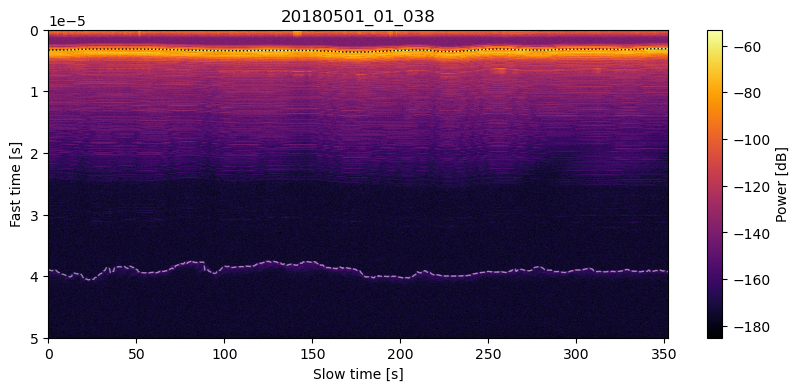

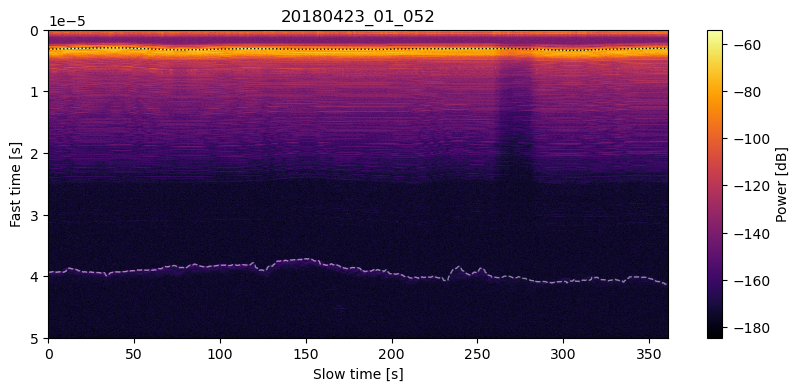

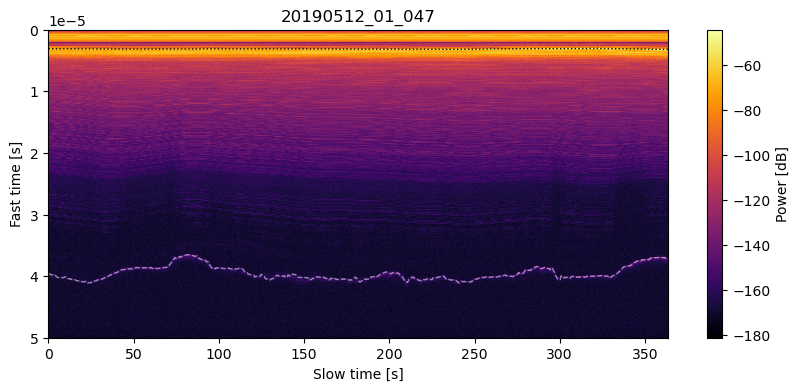

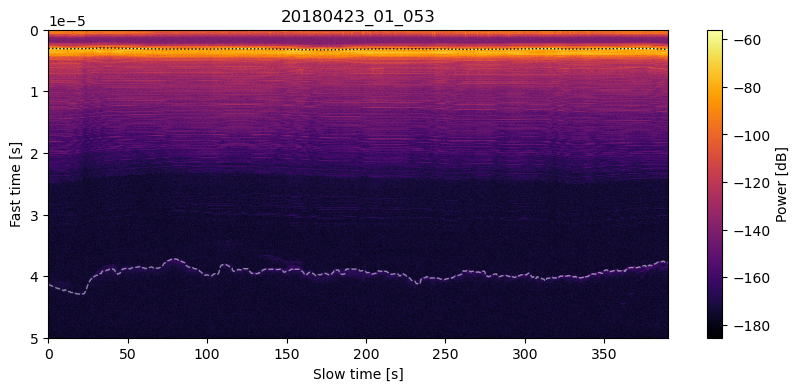

In [5]:
for line_name, line in lines.items():
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    pcm = ax.pcolormesh(line['slow_time_rel'], line['fast_time'], line['pwr_db'], cmap='inferno')
    fig.colorbar(pcm, ax=ax, label='Power [dB]')

    ax.plot(line['slow_time_rel'], line['surface_s'], 'k', label='Surface', linestyle=':', linewidth=1)
    ax.plot(line['slow_time_rel'], line['bed_s'], 'w', label='Bed', linestyle='--', linewidth=1, alpha=0.5)

    ax.set_ylim([5e-5, 0])
    ax.set_ylabel('Fast time [s]')
    ax.set_xlabel('Slow time [s]')

    ax.set_title(line_name)

### Calculate RSSNR on each line

This cell does the actual calculations of RSSNR. Plots are produced with surface and bed power on the top and the RSSNR on the bottom. Filtering for roll angle is performed to remove any data where the aircraft might have been turning.

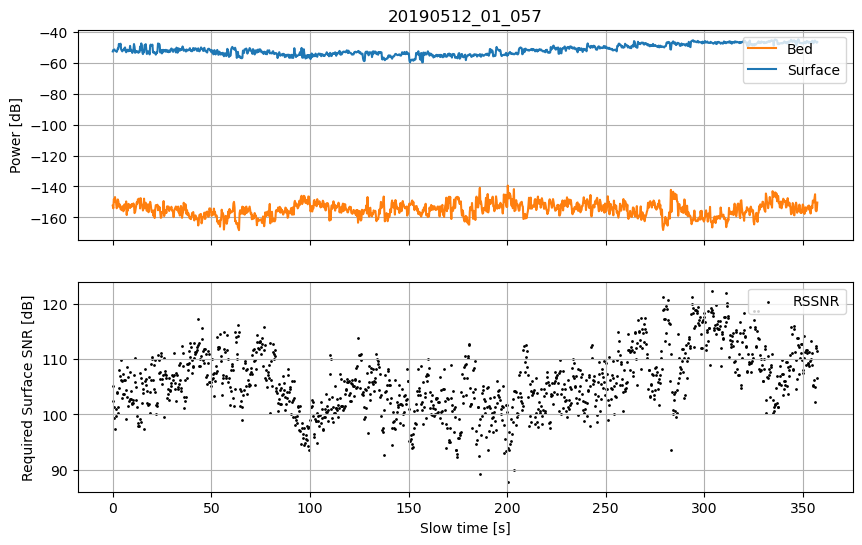

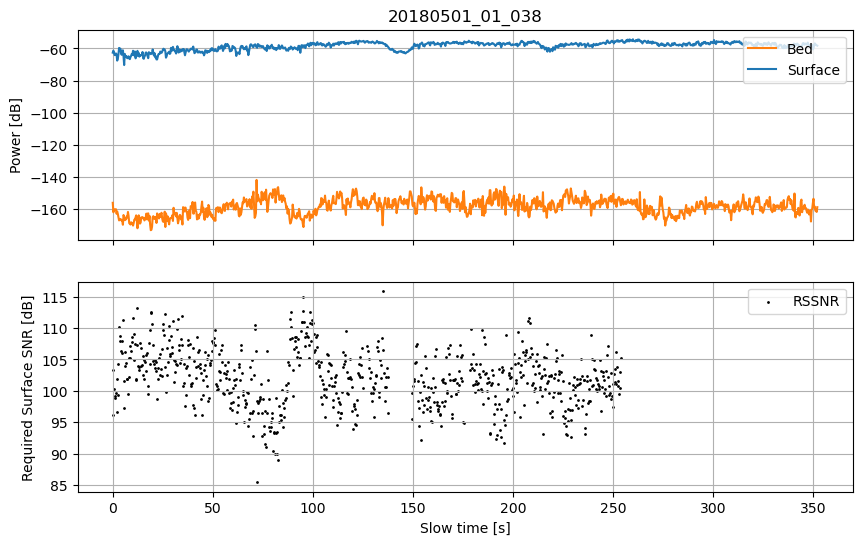

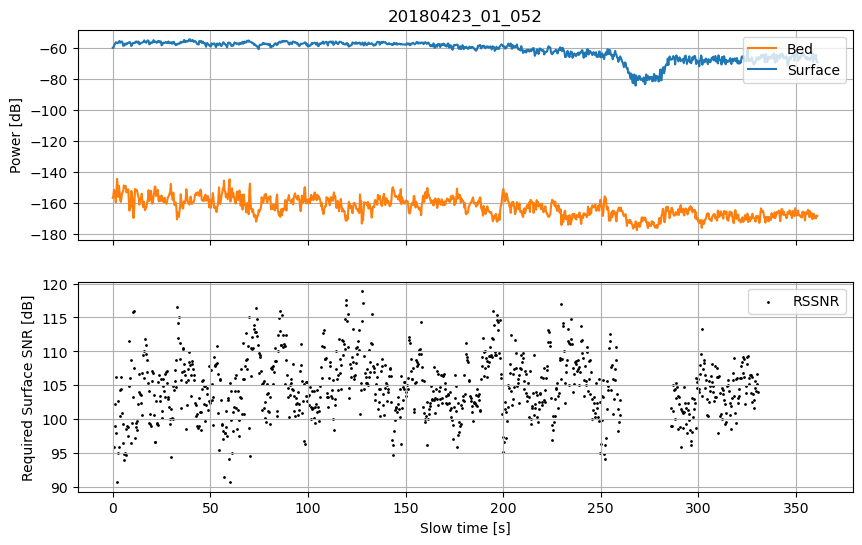

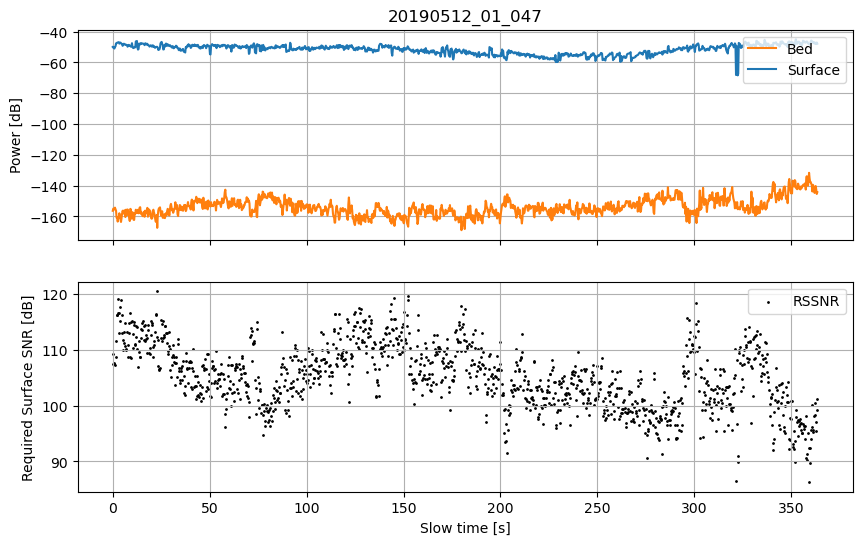

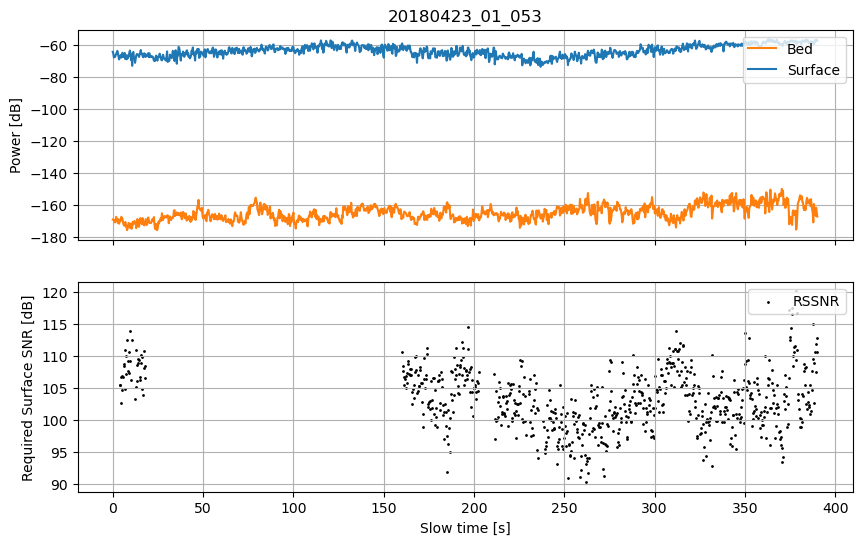

In [6]:
for line_name, line in lines.items():

    bed_sample_idx = np.array([np.argmin(np.abs(line['fast_time'] - x)) for x in line['bed_s']])
    bed_pwr = np.array([line['pwr_db'][ft_idx, st_idx] for st_idx, ft_idx in enumerate(bed_sample_idx)])
    bed_spreading_db = 2 * 10 * np.log10(2 * (line['surface_m'] + line['ice_thickness_m'] / np.sqrt(e_ice)))

    surface_sample_idx = np.array([np.argmin(np.abs(line['fast_time'] - x)) for x in line['surface_s']])
    surface_pwr = np.array([line['pwr_db'][ft_idx, st_idx] for st_idx, ft_idx in enumerate(surface_sample_idx)])
    surface_spreading_db = 2 * 10 * np.log10(2 * line['ice_thickness_m'])

    fig, (ax, ax_req_snr) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax.plot(line['slow_time_rel'], bed_pwr, c='tab:orange', label='Bed')
    ax.plot(line['slow_time_rel'], surface_pwr, c='tab:blue', label='Surface')

    ax.grid()
    ax.legend(loc='upper right')
    ax.set_ylabel('Power [dB]')

    line['req_surf_snr_without_spreading_correction'] = surface_pwr - bed_pwr
    line['req_surf_snr'] = surface_pwr - bed_pwr + surface_spreading_db - bed_spreading_db

    # Filter out turns
    roll = np.squeeze(line['l1_data']['Roll'])
    line['req_surf_snr'][np.abs(roll) > (np.pi/180)*5] = np.nan

    ax_req_snr.scatter(line['slow_time_rel'], line['req_surf_snr'], label='RSSNR', c='k', s=1)
    #ax_req_snr.scatter(line['slow_time_rel'], line['req_surf_snr_without_spreading_correction'], label='SNR without spreading correction', c='tab:orange', s=1)
    ax_req_snr.grid()

    ax_req_snr.set_xlabel('Slow time [s]')
    ax_req_snr.set_ylabel('Required Surface SNR [dB]')
    ax_req_snr.legend(loc='upper right')

    ax.set_title(line_name)

### Map of RSSNR

This produces a map of RSSNR. Look for spatial patterns here (real or artificial) and see if they make sense. Check that crossovers aren't too far off. Look for any outlier flights.

At Summit, we wouldn't expect any major differences. If you were in an area with more going on, you might expect to see stronger spatial patterns.

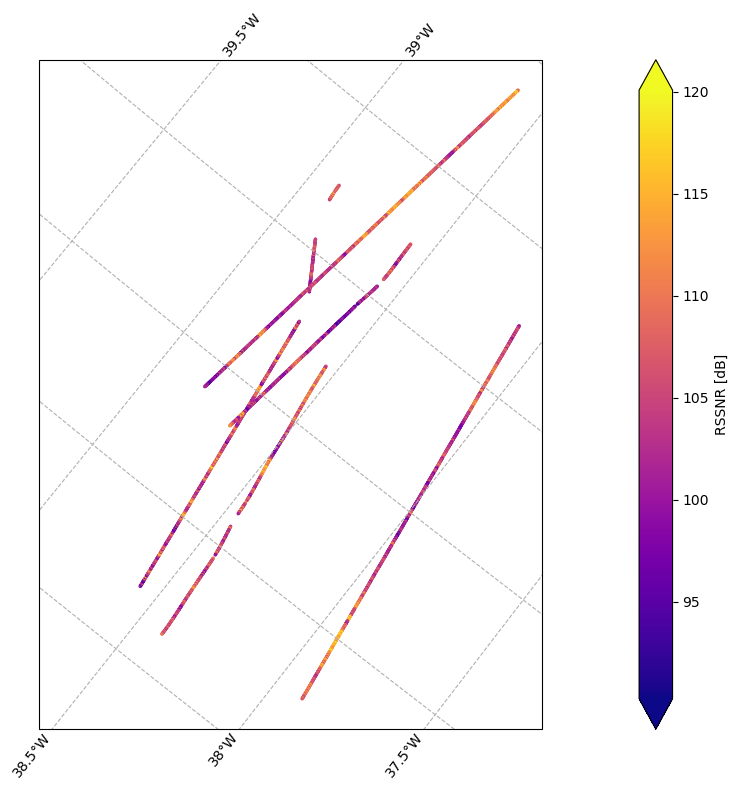

In [7]:
epsg_3413 = ccrs.Stereographic(central_longitude=0, central_latitude=90, false_easting=0, false_northing=0, globe=None)

# Make a cartopy plot in EPSG:3413
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': epsg_3413})

# Plot the locations of each line
sc = None
for line_name, line in lines.items():
    sc = ax.scatter(line['longitude'], line['latitude'], label=line_name, transform=ccrs.PlateCarree(), c=line['req_surf_snr'], cmap='plasma', s=2) #vmin=50, vmax=80, 
clb = fig.colorbar(sc, ax=ax, label='RSSNR [dB]', pad=0.1, extend='both')

# Add latitude and longitude labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')

fig.tight_layout()

plt.show()

### Histogram

Assuming that there is not a strong spatial pattern in your area, it's probably more useful to look at this as a distribution of RSSNR. The plot below shows the histogram and labels the 10th and 90th percentiles of RSSNR.

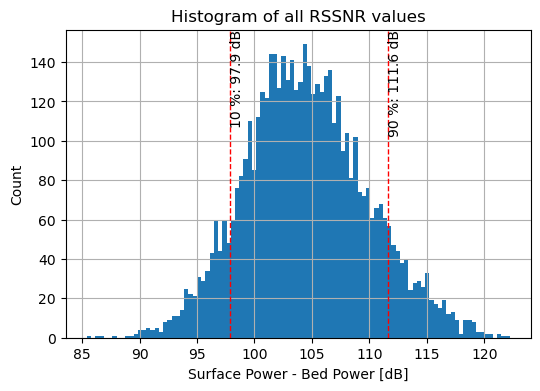

In [8]:
# Histogram of all surface - bed powers
all_req_surf_snr = np.concatenate([line['req_surf_snr'] for line in lines.values()])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(all_req_surf_snr, bins=100)
ax.set_xlabel('Surface Power - Bed Power [dB]')
ax.set_ylabel('Count')
ax.set_title('Histogram of all RSSNR values')   
ax.grid()

# Add vertical markers around 10th and 90th percentile
percentiles = [10, 90]
for percentile in percentiles:
    y = np.nanpercentile(all_req_surf_snr, percentile)
    ax.axvline(y, c='r', linestyle='--', linewidth=1)
    ax.text(y, ax.get_ylim()[1], f'{percentile} %: {y:.1f} dB', rotation=90, verticalalignment='top')

plt.show()